### Example of running model
In this example, the model is run for the study case documented in Leppä et al. (2022). The applied environmental forcing (see [data/forcing_readme.txt](data/forcing_readme.txt)) consist of half-hourly data for 2018-2019.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from photo import An_gs_model, pheno_cycle
from isotopes import oxygen_fractination, carbon_fractination, sourcewater_d18O
from parameters import phenop, photop

#### Read forcing and calculate additionally needed variables

In [2]:
# forcing data
forc = pd.read_csv(r'data\forcing.csv')
forc.index = pd.to_datetime(forc.iloc[:,0])

# phenological cycle (based on daily temperature) - note! for this starting date should be January 1rst.
forc['Tdaily'] = forc['Tair'].resample('D').mean()
forc['fpheno'] = pheno_cycle(phenop, forc['Tdaily'].fillna(method='ffill'),
                             forc.index.dayofyear)

# relative extracteble water (water limitation of photosynthesis based on this)
# where wilting point 0.03 and field capacity 0.3
forc['Rew'] = np.minimum(1, (forc['Ws'] - 0.03) /(0.3 - 0.03))

# timesteps [s]
dt = (forc.index[1:] - forc.index[:-1]).total_seconds()

# source water oxygen isopic compition
forc['d18O_sw'] = sourcewater_d18O(forc[['ET','Prec','d18O_prec','Ws','Tair']].copy(), layerdepth=0.2)

#### Running leaf-level photosynthesis

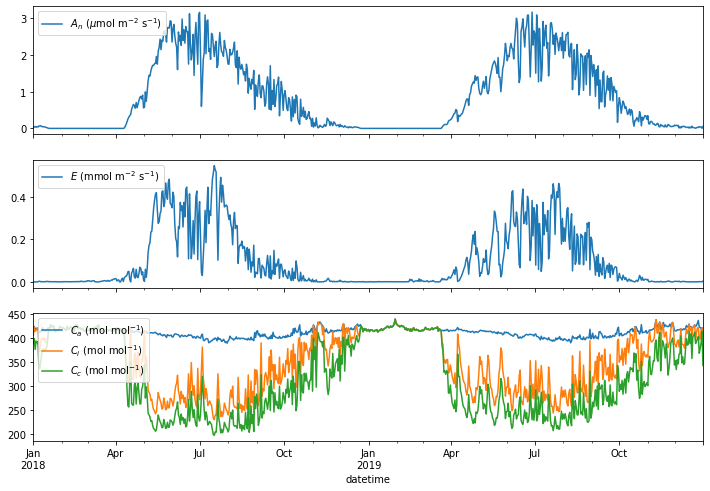

In [3]:
# leaf temperature assumed to be at air temperature
Tl = forc['Tair']

# run model
An, Rd, Rp, E, gs, gm, Cs, Ci, Cc, Tau_c = An_gs_model(
    photop, forc['Par'], Tl, forc['H2O'], forc['CO2'],
    photop['gb_c'], photop['gb_v'], P=forc['P'], fpheno=forc['fpheno'],
    Rew=forc['Rew'])

# figure of results at daily timescale
fig, axes = plt.subplots(3,1, figsize=(12,8), sharex=True)
An.resample('1D').mean().plot(ax=axes[0], label='$A_n$ ($\mu$mol m$^{-2}$ s$^{-1}$)')
E2 = 1e3*E
E2.resample('1D').mean().plot(ax=axes[1], label='$E$ (mmol m$^{-2}$ s$^{-1}$)')
forc['CO2'][forc['Zen']<0.5*np.pi].resample('1D').median().plot(ax=axes[2], label='$C_a$ (mol mol$^{-1}$)')
Ci[forc['Zen']<0.5*np.pi].resample('1D').median().plot(ax=axes[2], label='$C_i$ (mol mol$^{-1}$)')
Cc[forc['Zen']<0.5*np.pi].resample('1D').median().plot(ax=axes[2], label='$C_c$ (mol mol$^{-1}$)')
for ax in axes:
    ax.legend(loc='upper left')

#### Running leaf-level isotope models

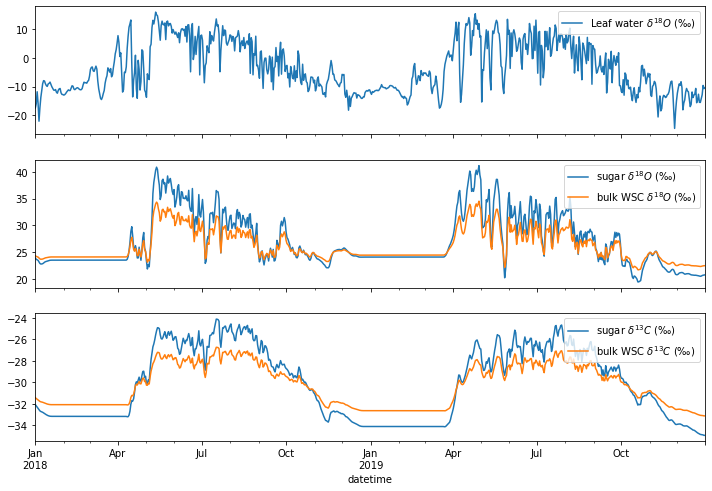

In [4]:
# --- d13C ---
_, d13c_flux, d13c_sugar, d13c_bulk = carbon_fractination(
    forc['CO2'], Cs, Ci, Cc, An, Rd, Tau_c, forc['d13Ca'],
    dt=dt, sugar_sto=1.96e5, ratio_pinitol=0.41, d13c_pinitol=-30.5)

# --- d18O --- 
# temperature-dependent biochemical fractionation factor (sternberg et al. 2011)
e_wc = 0.0084*Tl**2 - 0.51*Tl + 33.172 

_, d18o_lw, d18o_sugar, d18o_bulk = oxygen_fractination(
    E, An, Rd, forc['H2O'], photop['gb_v'], 1.6*gs, d18o_xylem=forc['d18O_sw'],
    d18o_vapor=forc['d18Ov'], T=Tl, dt=dt, P=forc['P'], Vlw=5.,
    sugar_sto=1.96e5, L_eff=0.03, nonsteadystate=True, e_wc=1e-3*e_wc,
    ratio_pinitol=0.41, d18o_pinitol=25.)

# figure of results (mean of 12 to 3 pm)
fig, axes = plt.subplots(3,1, figsize=(12,8), sharex=True)
ix = (forc.index.hour >= 12) & (forc.index.hour < 15)
d18o_lw[ix].resample('1D').mean().plot(ax=axes[0], label='Leaf water $\delta^{18}O$ (‰)')
d18o_sugar[ix].resample('1D').mean().plot(ax=axes[1], label='sugar $\delta^{18}O$ (‰)')
d18o_bulk[ix].resample('1D').mean().plot(ax=axes[1], label='bulk WSC $\delta^{18}O$ (‰)')
d13c_sugar[ix].resample('1D').mean().plot(ax=axes[2], label='sugar $\delta^{13}C$ (‰)')
d13c_bulk[ix].resample('1D').mean().plot(ax=axes[2], label='bulk WSC $\delta^{13}C$ (‰)')
for ax in axes:
    ax.legend(loc='upper right')